# Credit Analysis
    a.	Preprocess and clean if necessary.
    b.	Build a model predicting “Risk”. 
    c.	Remember to comment your code and give rationales for models, algorithms, and approaches. 


## Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

## Load data

In [3]:
import pyodbc
import urllib
import sqlalchemy

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [4]:
df=pd.read_sql_table(r"credit_train",engine_datahub)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


## Exploratory Data Analysis(EDA)



### Check missing values and shape
Normally we need to clean the samples, i,e, impute missing values but in this case the data is pretty clean with no missing values. We also check the shape to make sure it matches the meta data info in the document. 

In [5]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

(None, (100514, 19))

### Check Loan Status ratio
The samples are balanced so we can use "Accuracy" metric to measure the performance of the model

<AxesSubplot:>

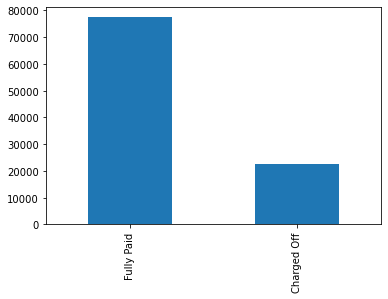

In [6]:
df['Loan Status'].value_counts().plot(kind='bar')

### Describe the data

Categorical features/Dimensions 

In [7]:
cat_cols=df.select_dtypes(object).drop(['Loan ID','Customer ID'],axis=1).columns.tolist()
cat_cols

['Loan Status', 'Term', 'Years in current job', 'Home Ownership', 'Purpose']

C:\Users\ABC\AppData\Local\Temp/ipykernel_22640/323911355.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


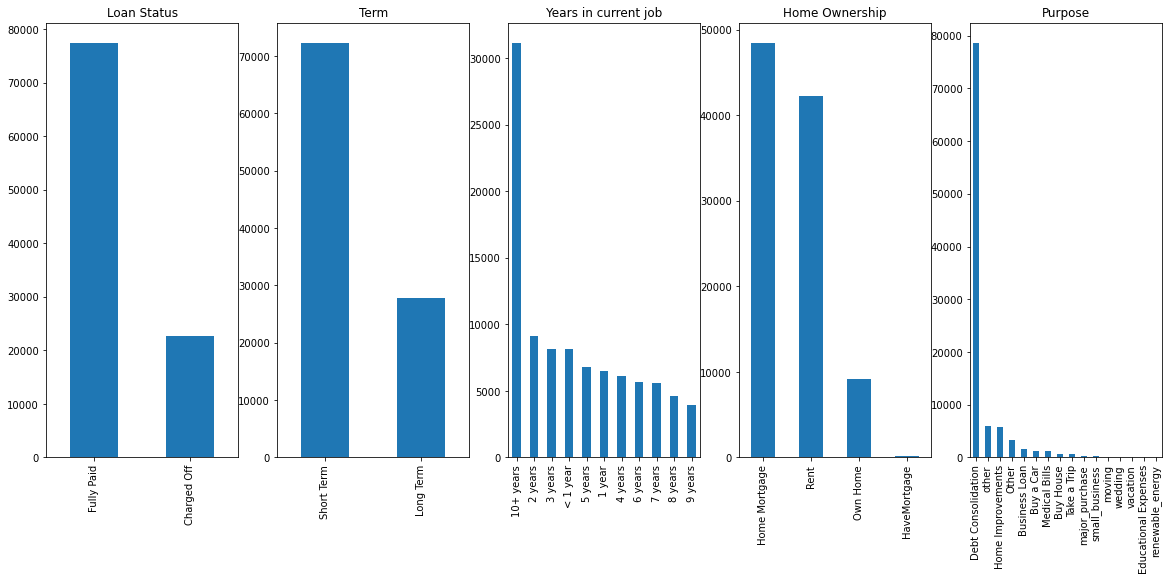

In [8]:
import matplotlib.pyplot as plt
categorical_features = cat_cols
# fig, ax = plt.subplots(1, len(categorical_features))
fig, ax = plt.subplots(1, len(categorical_features))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i],figsize=(20,8),rot=90,fontsize=10).set_title(categorical_feature)
fig.show()

Numeric data

#### Histogram
Histogram groups numeric data into bins, displaying the bins as segmented columns and summarize the distribution of a univariate data set. 

In [9]:
num_cols=df.select_dtypes('number').columns.tolist()
num_cols

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Monthly Debt',
 'Years of Credit History',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Bankruptcies',
 'Tax Liens']

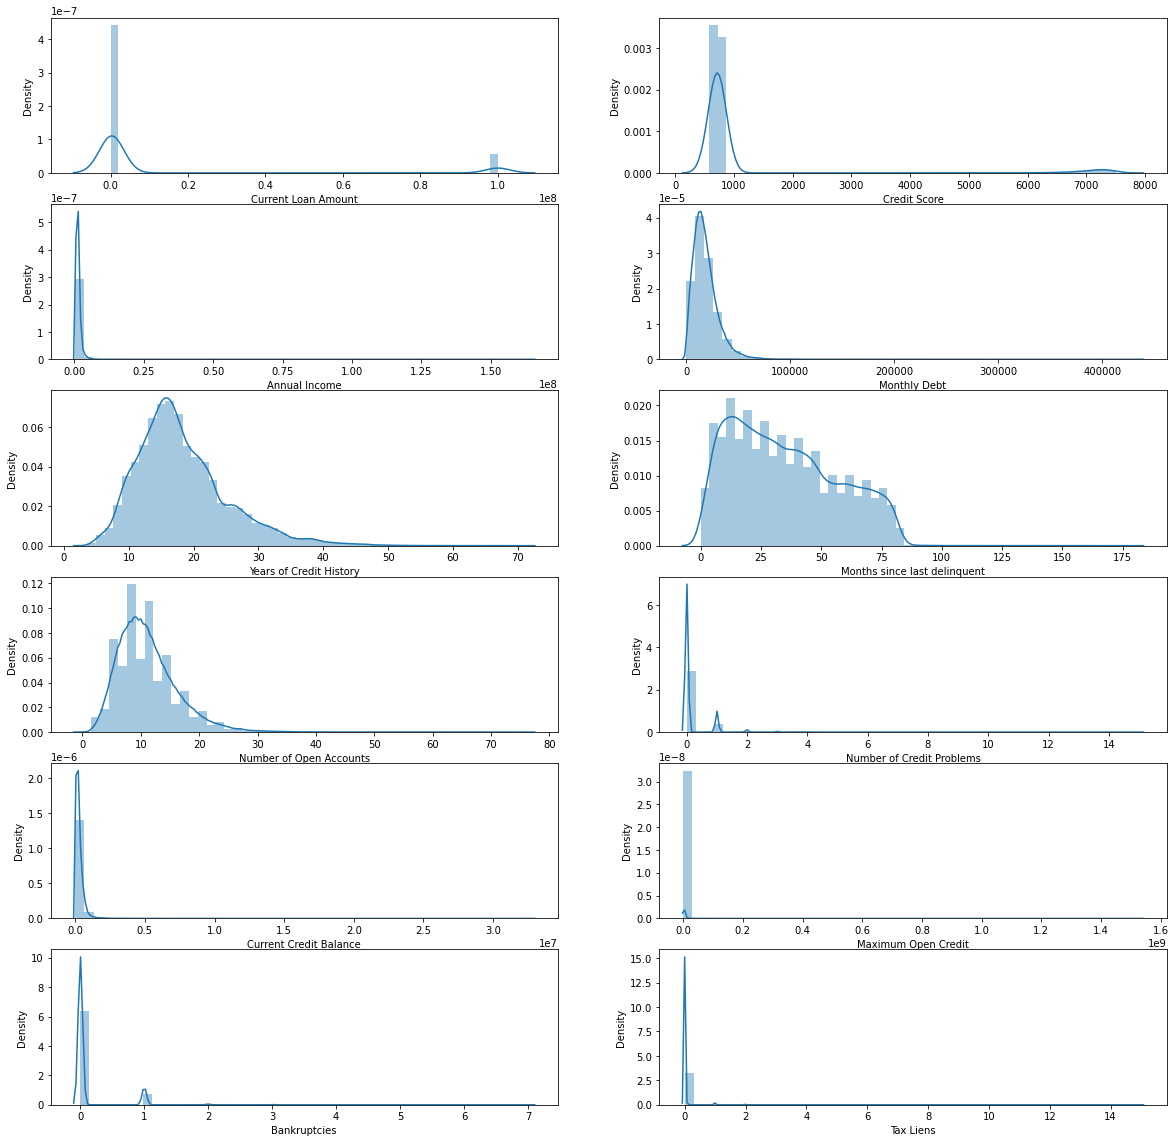

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, ax = plt.subplots(6, 2, figsize=(20, 20))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.distplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],bins=50)

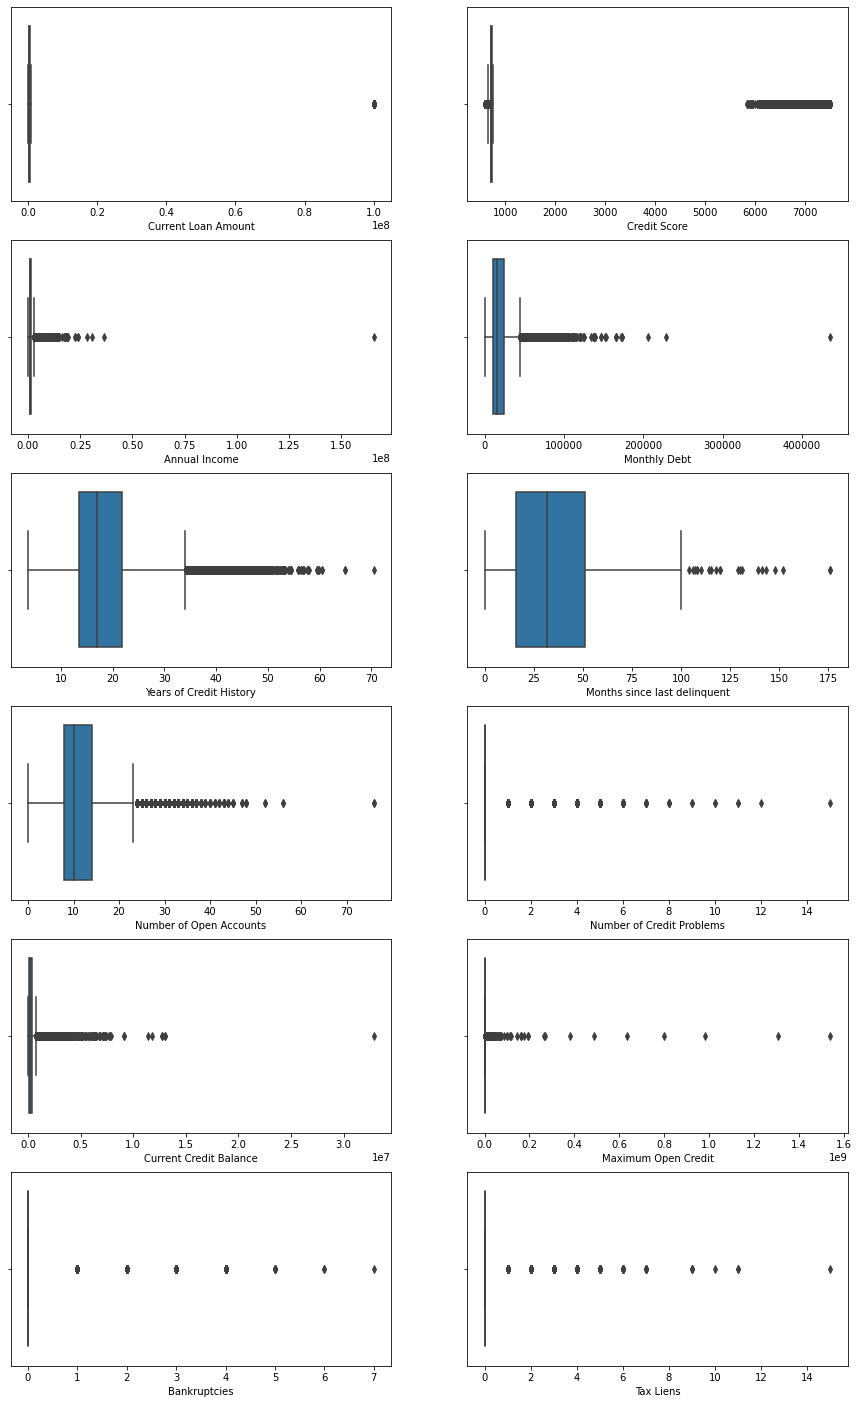

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

fig, ax = plt.subplots(6, 2, figsize=(15, 25))

#plot the features except LOCATION_ID and Risk
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
#         sns.boxplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],orient='v',showfliers=False)
        sns.boxplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],orient='v')

In [12]:
df.describe()
# from the "max" row we can see feature PARA_A, PARA_B,Money_Value,History have some potential outliers. 

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,1.000000e+05,80846.000000,8.084600e+04,100000.000000,100000.000000,46859.000000,100000.00000,100000.000000,1.000000e+05,9.999800e+04,99796.000000,99990.000000
mean,1.176045e+07,1076.456089,1.378277e+06,18472.412336,18.199141,34.901321,11.12853,0.168310,2.946374e+05,7.607984e+05,0.117740,0.029313
std,3.178394e+07,1475.403791,1.081360e+06,12174.992609,7.015324,21.997829,5.00987,0.482705,3.761709e+05,8.384503e+06,0.351424,0.258182
min,1.080200e+04,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.796520e+05,705.000000,8.488440e+05,10214.162500,13.500000,16.000000,8.00000,0.000000,1.126700e+05,2.734380e+05,0.000000,0.000000
50%,3.122460e+05,724.000000,1.174162e+06,16220.300000,16.900000,32.000000,10.00000,0.000000,2.098170e+05,4.678740e+05,0.000000,0.000000
75%,5.249420e+05,741.000000,1.650663e+06,24012.057500,21.700000,51.000000,14.00000,0.000000,3.679588e+05,7.829580e+05,0.000000,0.000000
max,1.000000e+08,7510.000000,1.655574e+08,435843.280000,70.500000,176.000000,76.00000,15.000000,3.287897e+07,1.539738e+09,7.000000,15.000000


In [13]:
df['Credit Score']=np.where(df['Credit Score']>=1000,df['Credit Score']/10,df['Credit Score'])

In [14]:
df['Current Loan Amount']=np.where(df['Current Loan Amount']==99999999,df['Current Loan Amount'].median(),df['Current Loan Amount'])

In [15]:
df.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,100000.000000,80846.000000,8.084600e+04,100000.000000,100000.000000,46859.000000,100000.00000,100000.000000,1.000000e+05,9.999800e+04,99796.000000,99990.000000
mean,312305.834940,716.293447,1.378277e+06,18472.412336,18.199141,34.901321,11.12853,0.168310,2.946374e+05,7.607984e+05,0.117740,0.029313
std,175240.815085,28.297164,1.081360e+06,12174.992609,7.015324,21.997829,5.00987,0.482705,3.761709e+05,8.384503e+06,0.351424,0.258182
min,10802.000000,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,179652.000000,703.000000,8.488440e+05,10214.162500,13.500000,16.000000,8.00000,0.000000,1.126700e+05,2.734380e+05,0.000000,0.000000
50%,312246.000000,722.000000,1.174162e+06,16220.300000,16.900000,32.000000,10.00000,0.000000,2.098170e+05,4.678740e+05,0.000000,0.000000
75%,402292.000000,738.000000,1.650663e+06,24012.057500,21.700000,51.000000,14.00000,0.000000,3.679588e+05,7.829580e+05,0.000000,0.000000
max,789250.000000,751.000000,1.655574e+08,435843.280000,70.500000,176.000000,76.00000,15.000000,3.287897e+07,1.539738e+09,7.000000,15.000000


### Clip, i.e. assigns values outside boundary to boundary values, the data to deal with outliers. 
 Outliers may distort how we see the data. They contain information too so it's a tradeoff; we lose some info but gain a better big picture of the data.

In [16]:
df['Years in current job']=df['Years in current job'].str[:2].replace({'< ':'0.5'}).astype(float)

In [17]:
# here we use quantile 0.01 as lower limit and 0.99 upper.
df[num_cols]=df[num_cols].clip(lower=df[num_cols].quantile(0.01), upper=df[num_cols].quantile(0.99),axis=1)
df.describe()

,Current Loan Amount,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,100000.000000,80846.000000,8.084600e+04,95778.000000,100000.000000,100000.000000,46859.000000,100000.000000,100000.000000,1.000000e+05,9.999800e+04,99796.000000,99990.000000
mean,312347.348280,716.421926,1.356195e+06,5.934975,18328.885249,18.164207,34.874987,11.095860,0.158530,2.830483e+05,6.251740e+05,0.110445,0.019282
std,174940.776601,27.766647,7.485277e+05,3.563923,11372.300056,6.835628,21.896521,4.841969,0.413715,2.596546e+05,5.653909e+05,0.313446,0.137515
min,37861.780000,621.000000,3.458637e+05,0.500000,1249.816200,6.400000,1.000000,3.000000,0.000000,2.831000e+03,2.642068e+04,0.000000,0.000000
25%,179652.000000,703.000000,8.488440e+05,3.000000,10214.162500,13.500000,16.000000,8.000000,0.000000,1.126700e+05,2.734380e+05,0.000000,0.000000
50%,312246.000000,722.000000,1.174162e+06,6.000000,16220.300000,16.900000,32.000000,10.000000,0.000000,2.098170e+05,4.678740e+05,0.000000,0.000000
75%,402292.000000,738.000000,1.650663e+06,10.000000,24012.057500,21.700000,51.000000,14.000000,0.000000,3.679588e+05,7.829580e+05,0.000000,0.000000
max,778404.000000,750.000000,4.586904e+06,10.000000,58741.374700,40.100000,81.000000,27.000000,2.000000,1.552585e+06,3.615757e+06,1.000000,1.000000


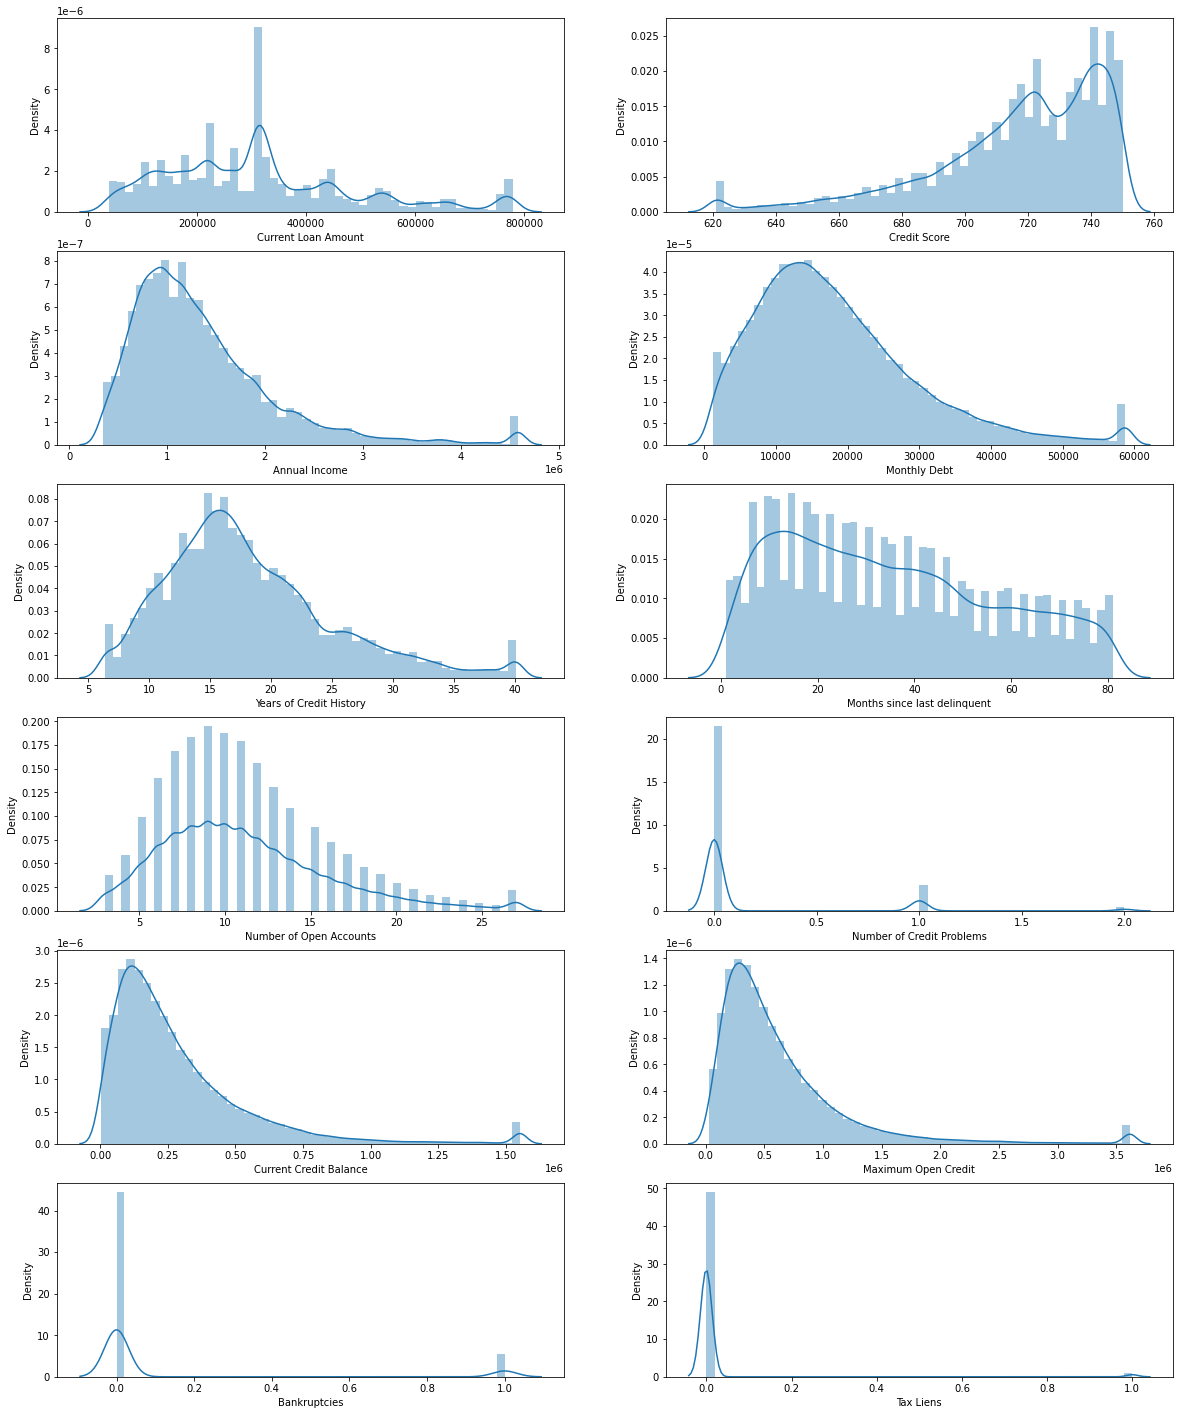

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, ax = plt.subplots(6, 2, figsize=(20, 25))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.distplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],bins=50)

### Boxplot the data
Boxplot shows the shape of the distribution, its central value, and its variability

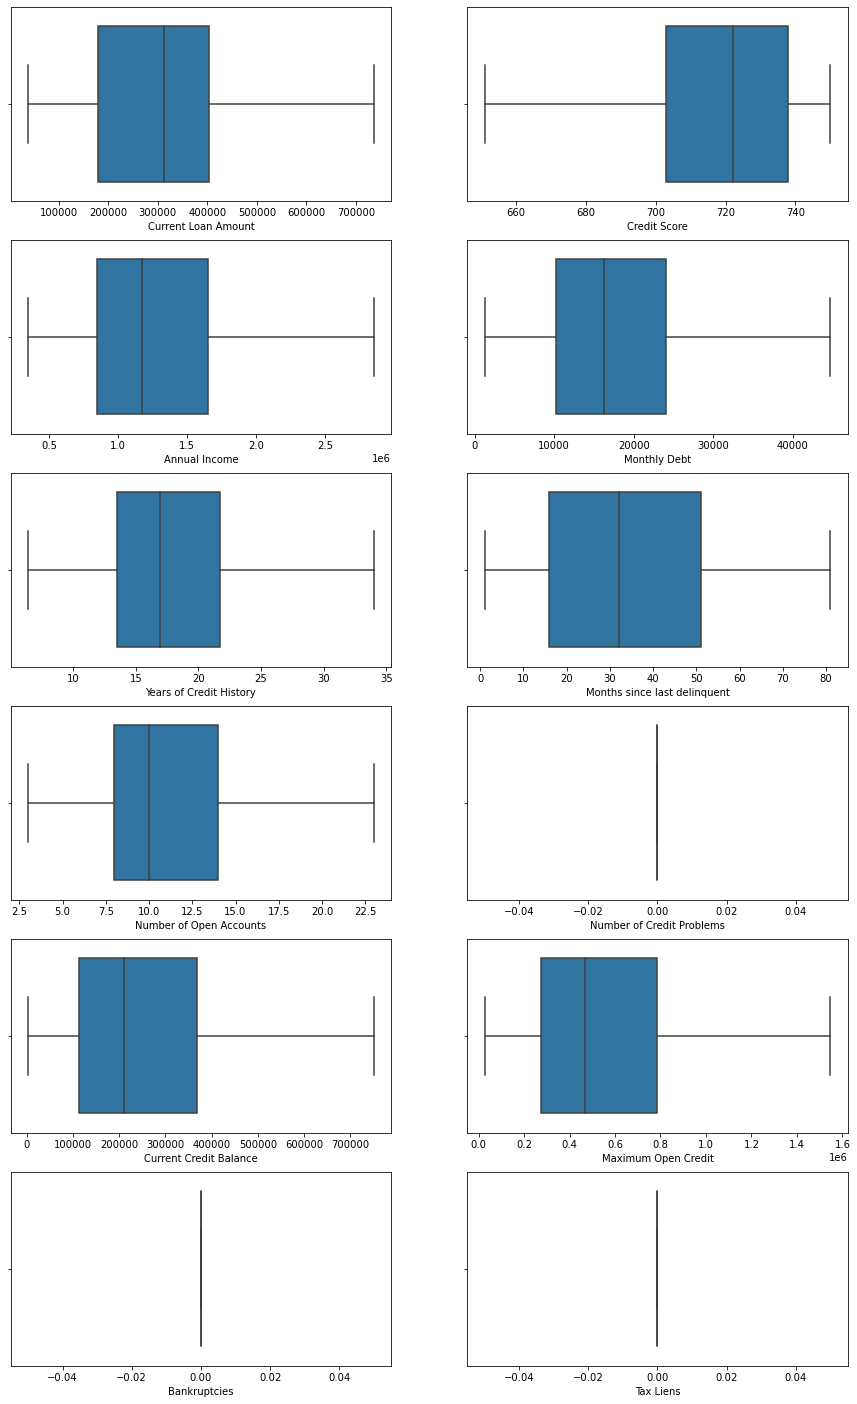

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

fig, ax = plt.subplots(6, 2, figsize=(15, 25))

#plot the features except LOCATION_ID and Risk
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.boxplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],orient='v',showfliers=False)

#### Explain the Boxplots:
The boxplots tell similar story as the Histograms. None of the distributions seem normal.

### Correlation heatmap
Correlation heatmap allows us to see relations between features/attributes. The higher the absolute coefficient, the stronger the correlation is. 

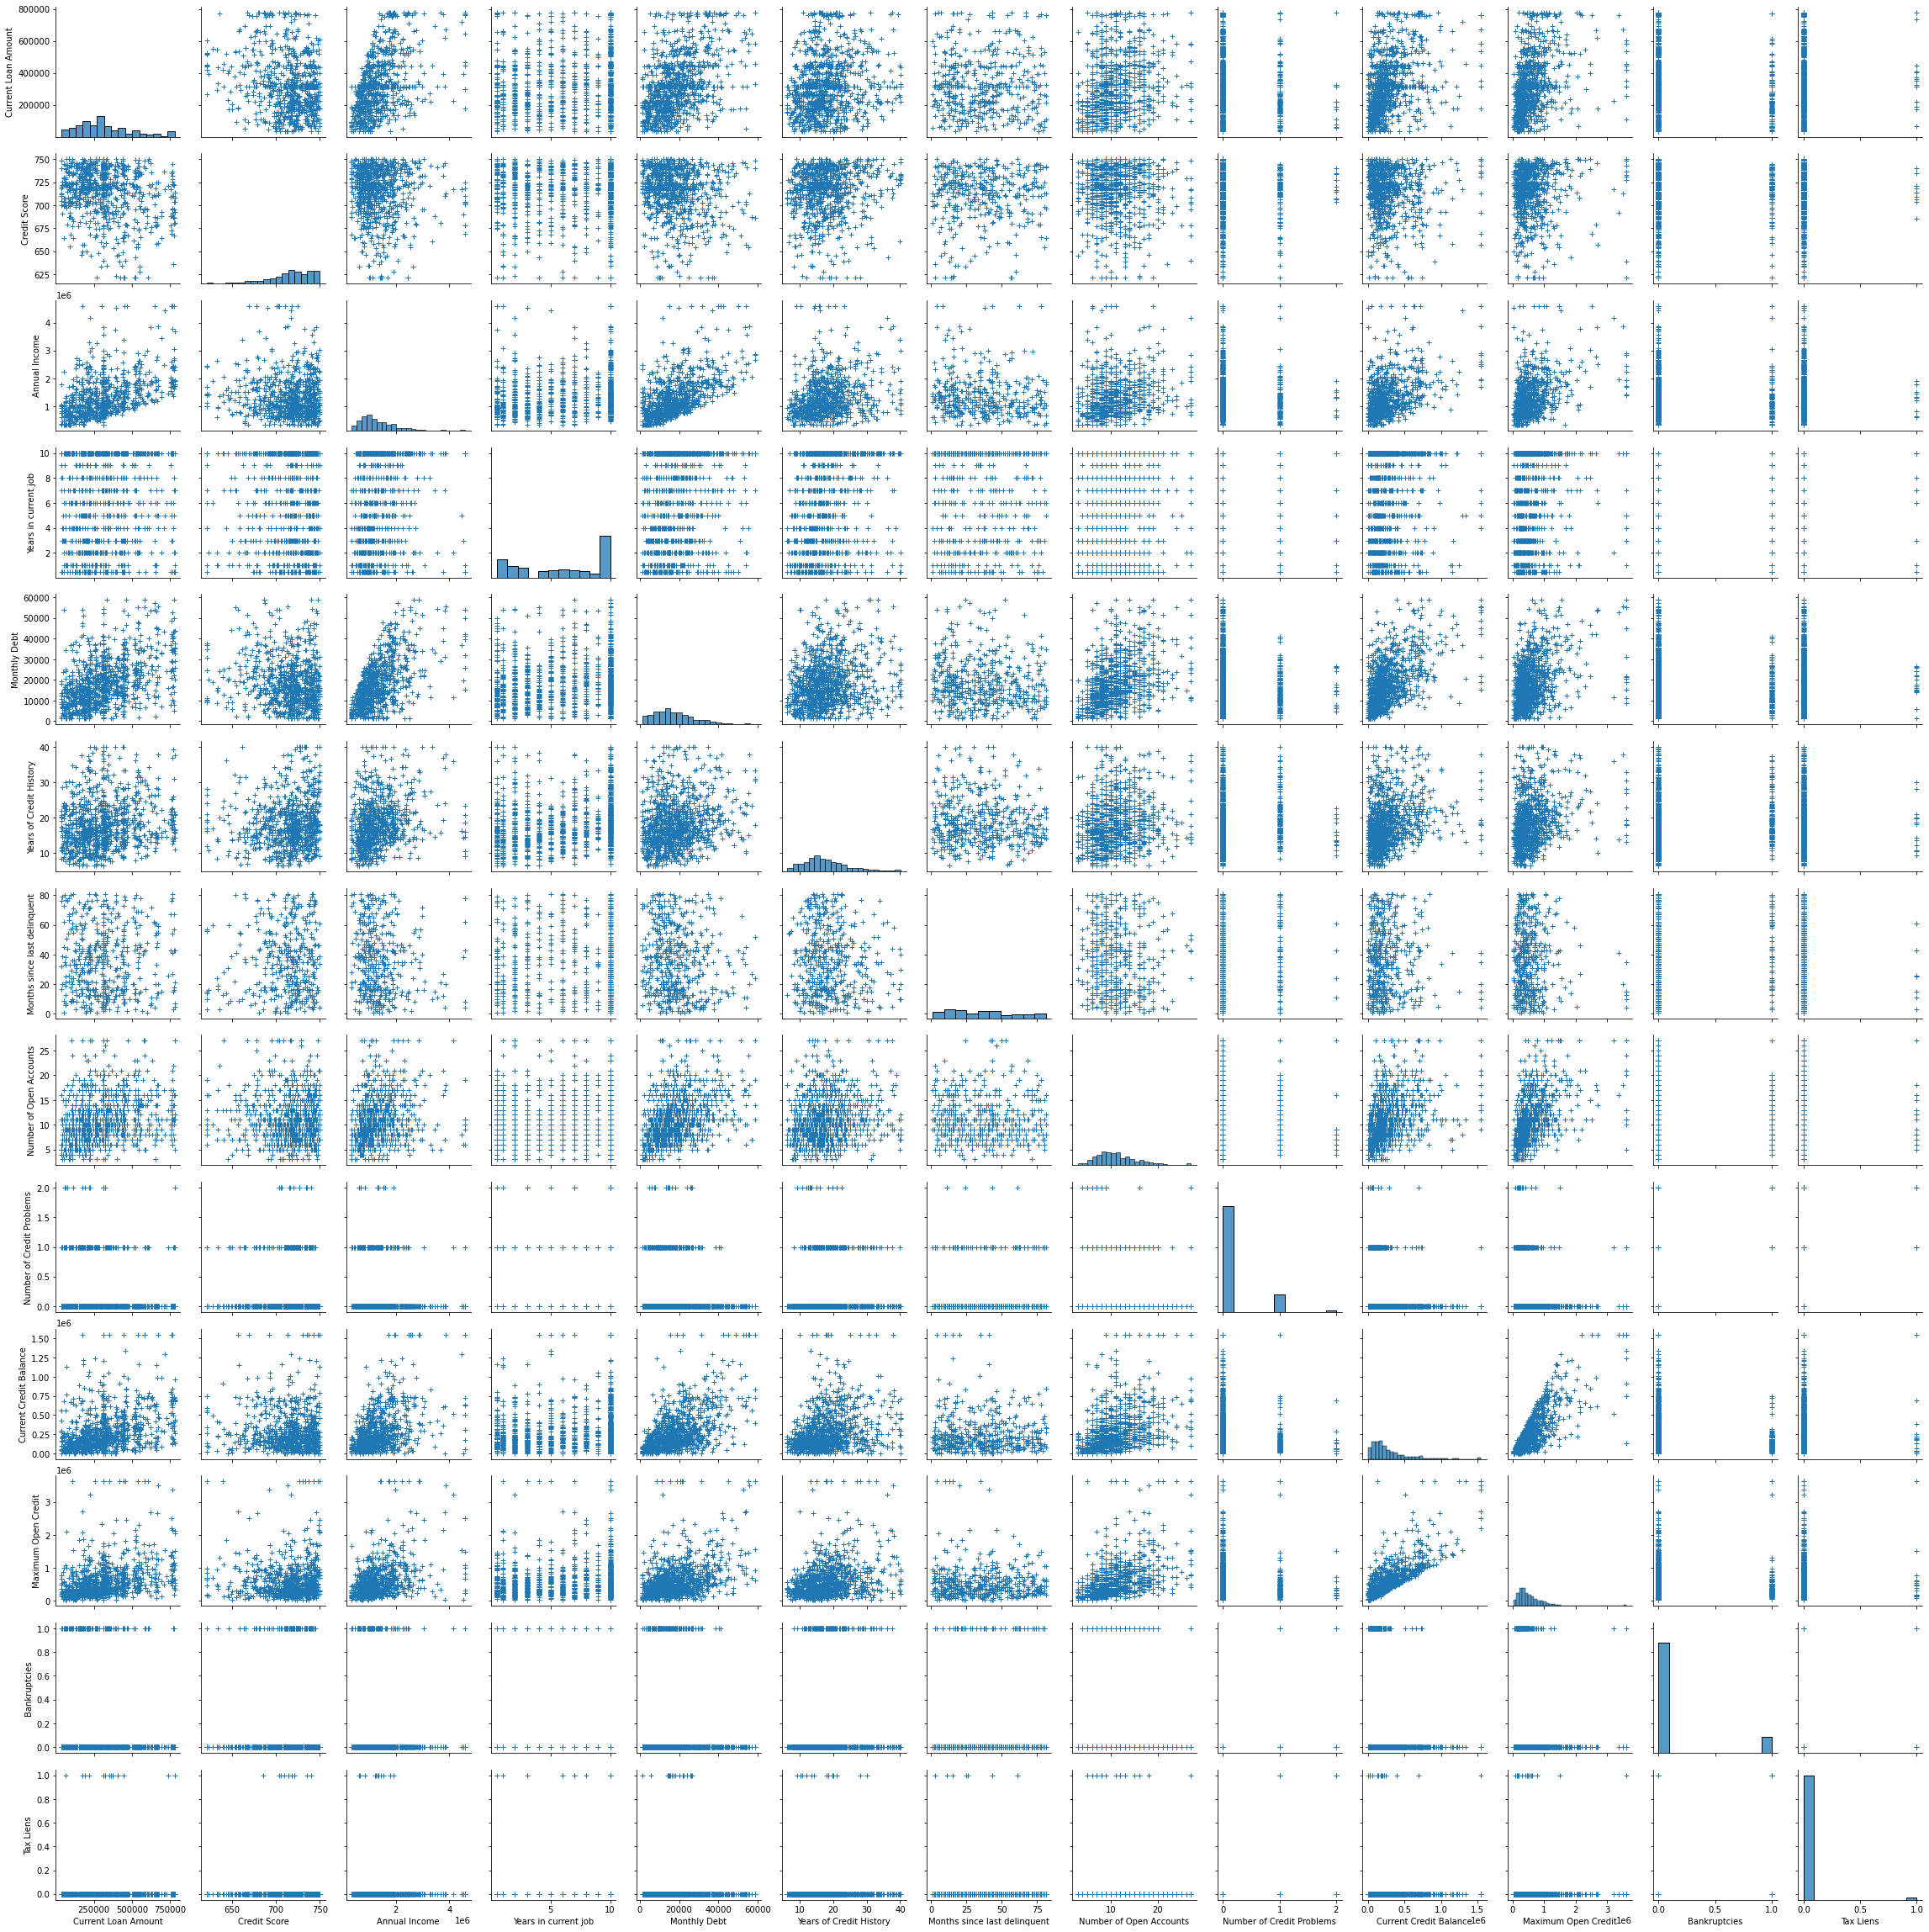

In [20]:
import seaborn as sns
df=df.query('`Loan ID`.notnull()', engine='python')
sns.pairplot(df.sample(frac=0.01, replace=True).reset_index(drop=True),plot_kws=dict(marker="+", linewidth=1))

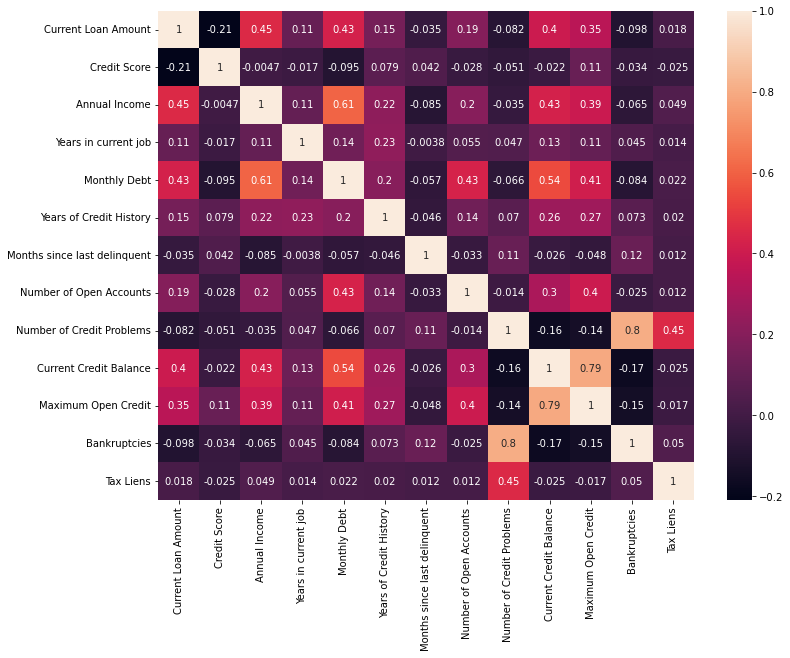

In [21]:

# df['Loan Status encoded']=np.where(df['Loan Status']=='Fully Paid',0,1)
corrMatrix = df.corr()
plt.figure(figsize = (12,9))
ax=(sns.heatmap(corrMatrix, annot=True))
plt.show()

Chi Square p value = 4.8299360525552625e-268


Loan Status,Charged Off,Fully Paid
Term,,
Long Term,8366,19426
Short Term,14273,57935


Loan Status,Charged Off,Fully Paid
Term,,
Long Term,0.301022,0.698978
Short Term,0.197665,0.802335


<AxesSubplot:xlabel='Loan Status', ylabel='Term'>

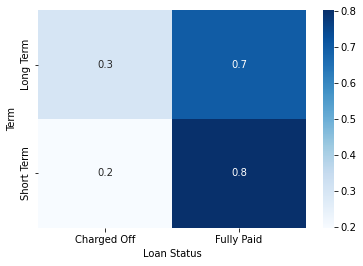

In [22]:
from scipy.stats import chisquare,chi2_contingency

v1=df['Term']
# v1=df['Purpose']
# v2=df['Home Ownership']
v2=df['Loan Status']
# g, p, dof, expctd=chi2_contingency(pd.crosstab(v1, v2))
print('Chi Square p value =' , chi2_contingency(pd.crosstab(v1, v2))[1])

display(pd.crosstab(v1, v2))
display(pd.crosstab(v1, v2,normalize='index'))
# sns.heatmap(pd.crosstab(v1, v2), annot=True)
sns.heatmap(pd.crosstab(v1, v2,normalize='index'), annot=True,cmap="Blues")


<AxesSubplot:>

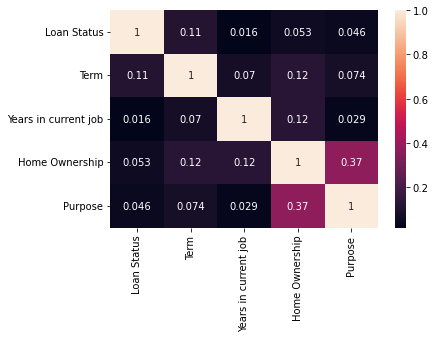

In [23]:
#import stats package
import scipy.stats as ss

#define the Cramér’s V function to get the association
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# create the dataset with association coefficeints for heatmap
g=pd.DataFrame()
cols=cat_cols
for c1 in cols:
    l=[]
    f=[]
    d=pd.DataFrame()
    
    for c2 in cols:
        l.append(cramers_v(df[c1],df[c2]))
        f.append(c2) 
        d=pd.concat([d,pd.DataFrame(l,columns=[c1],index=f)]).drop_duplicates()
    g=pd.concat([g,d],axis=1)

sns.heatmap(g,annot=True)

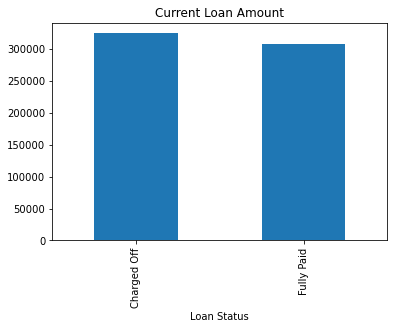

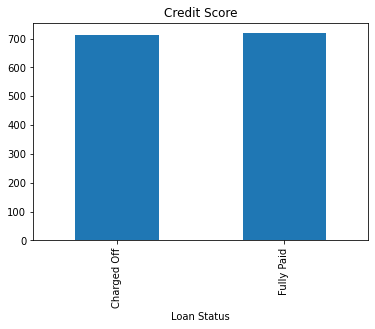

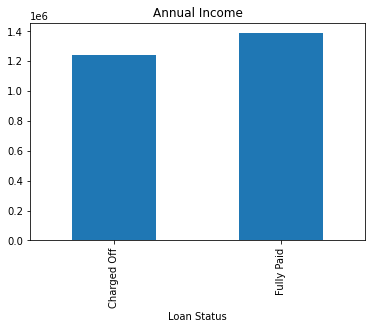

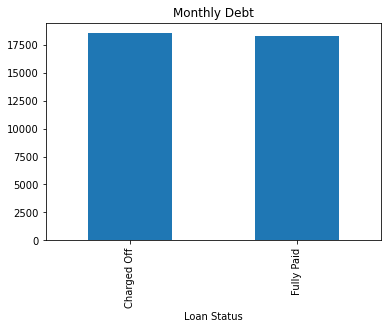

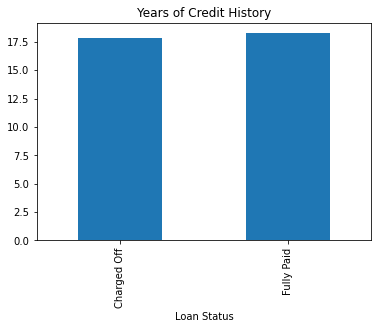

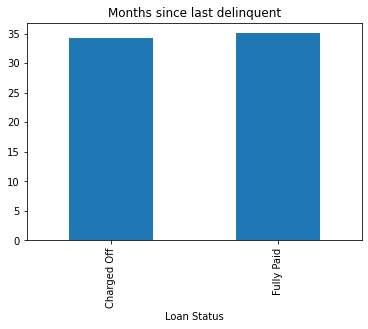

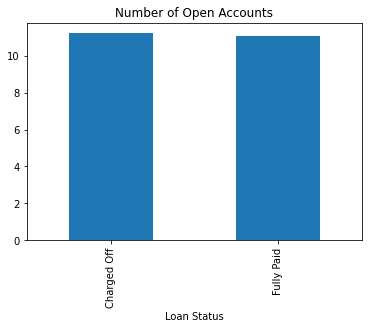

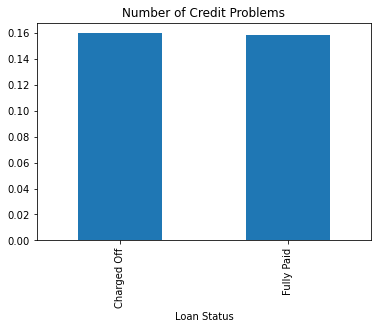

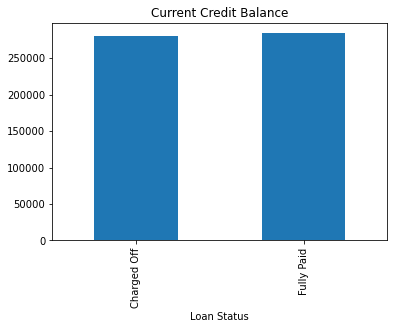

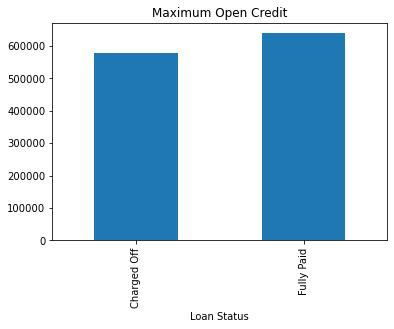

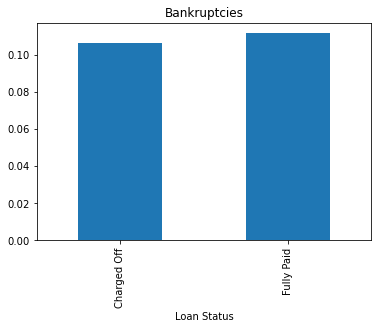

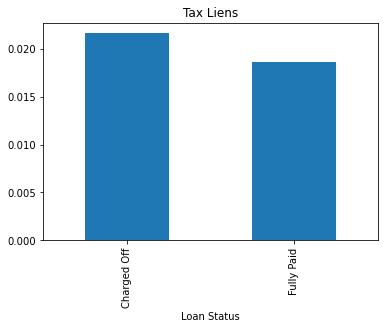

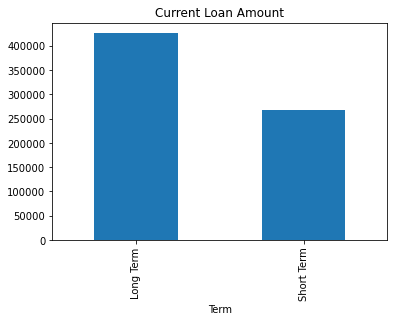

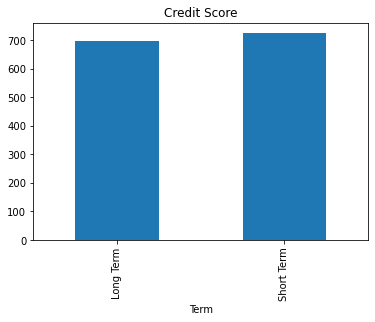

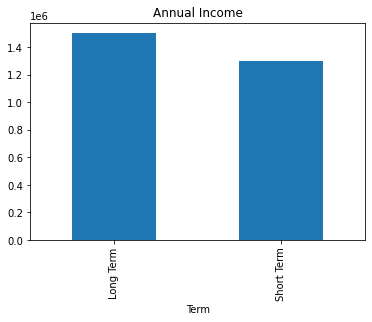

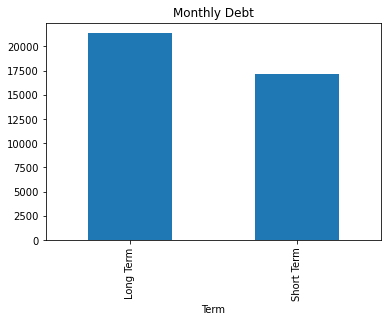

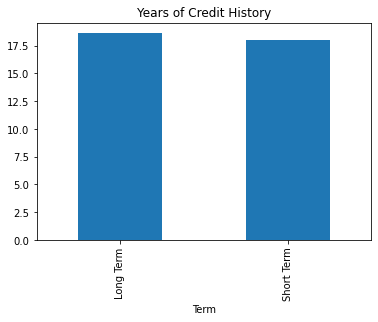

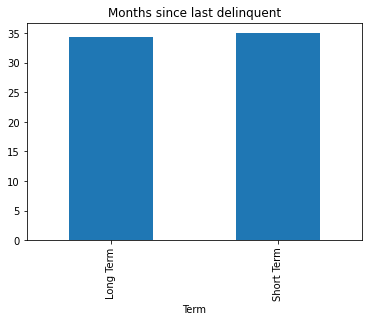

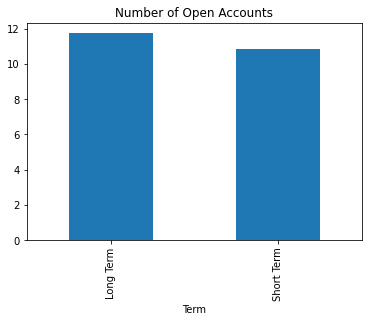

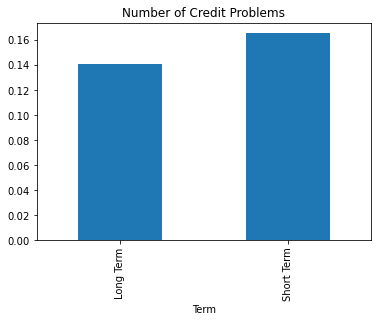

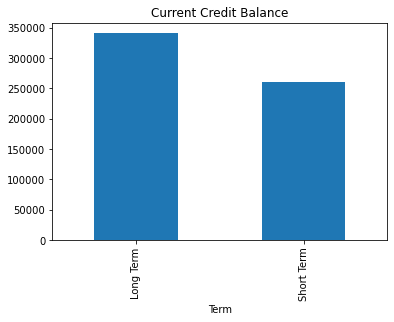

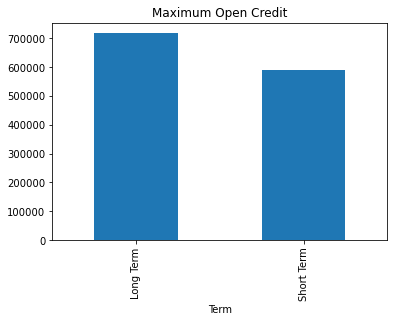

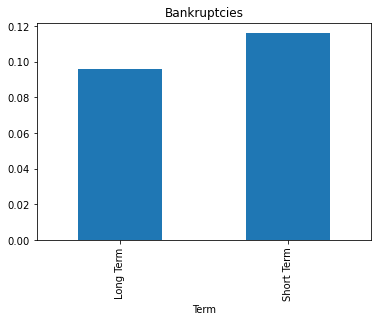

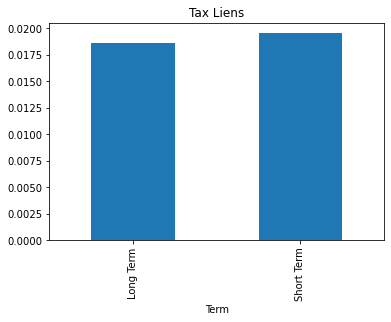

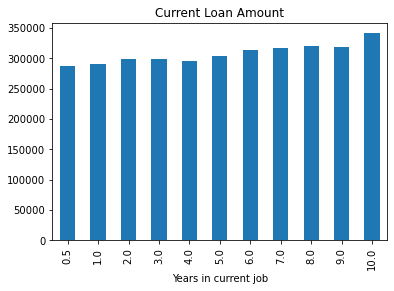

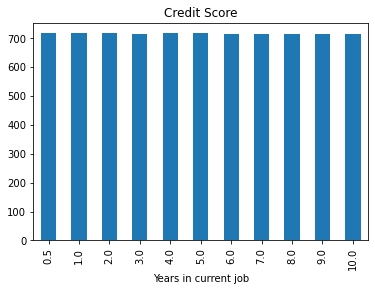

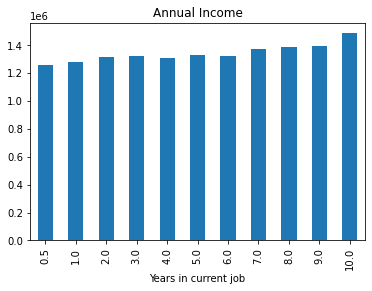

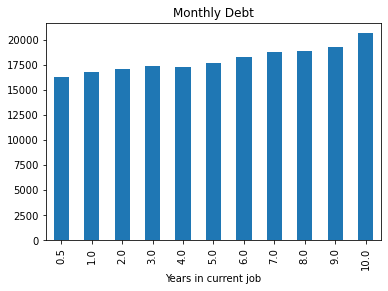

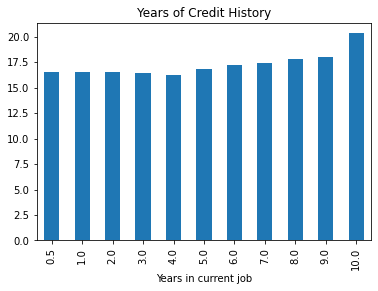

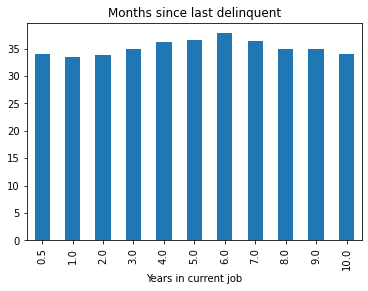

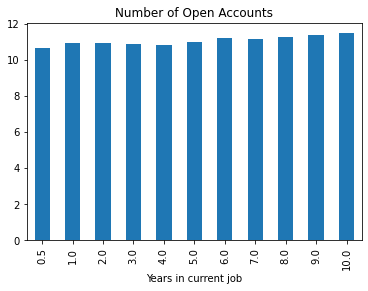

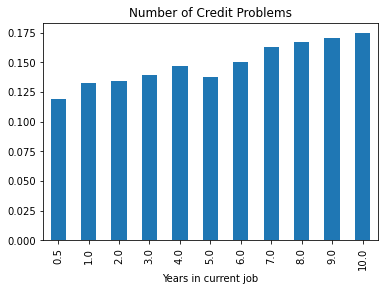

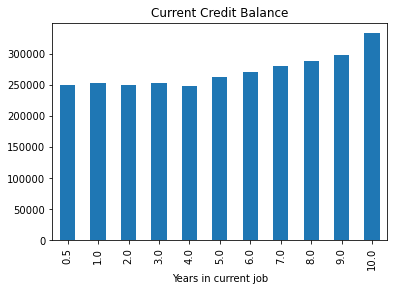

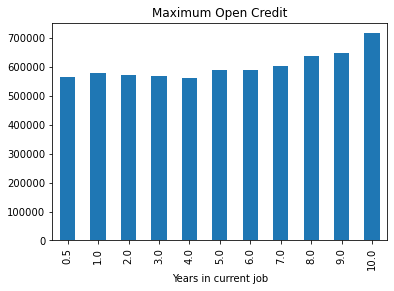

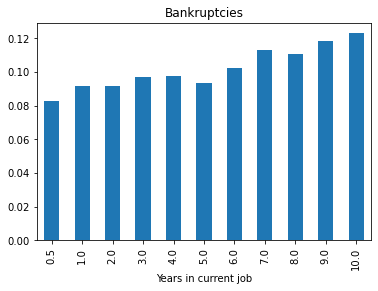

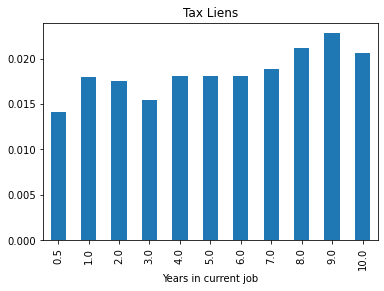

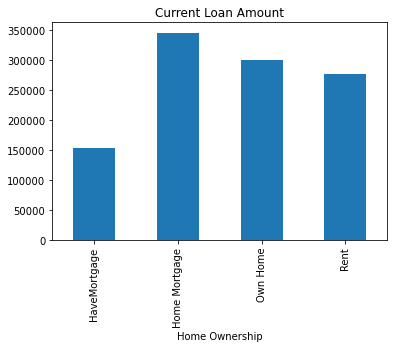

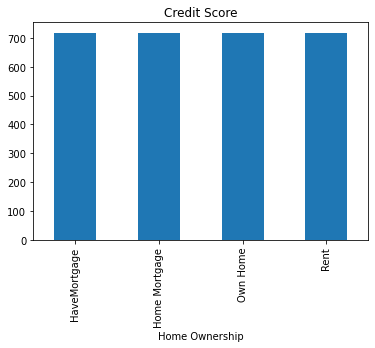

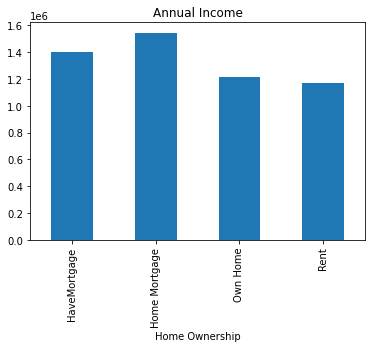

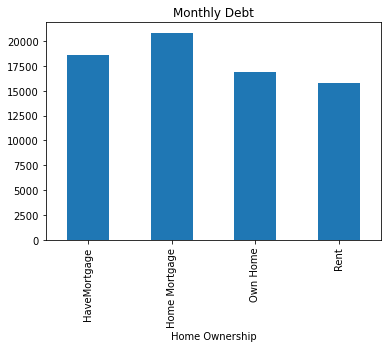

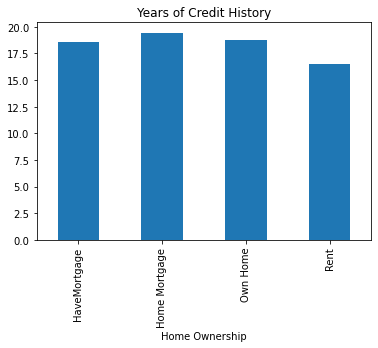

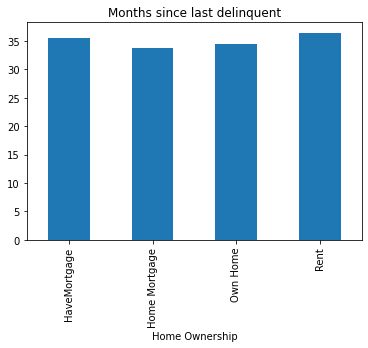

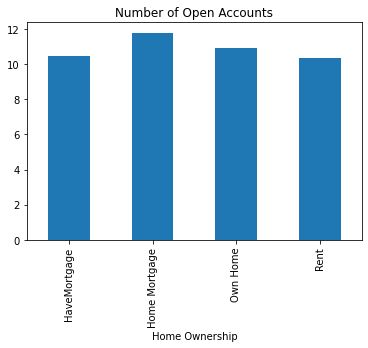

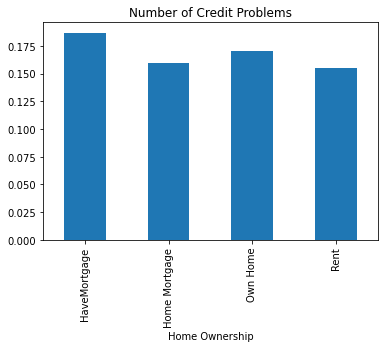

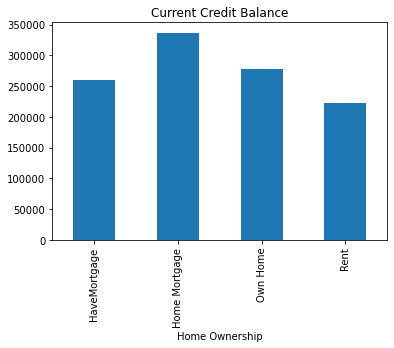

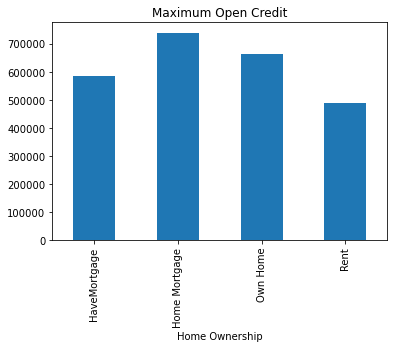

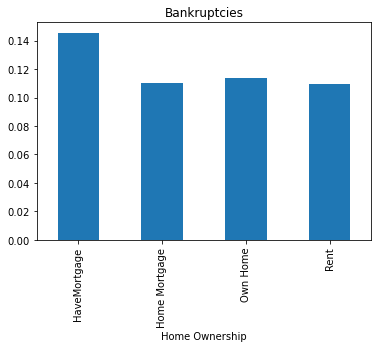

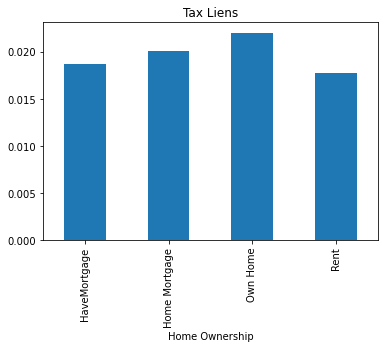

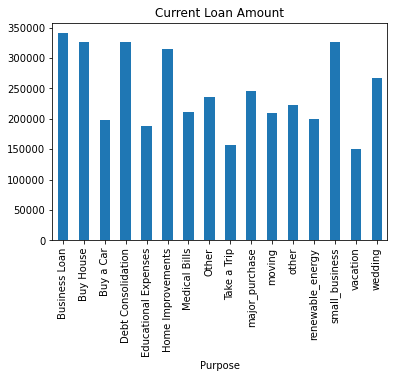

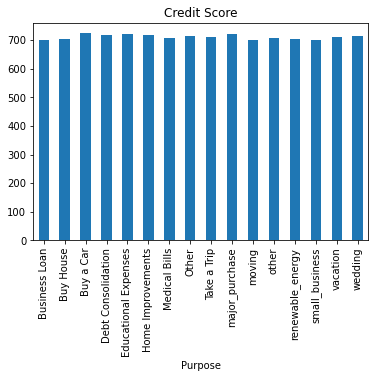

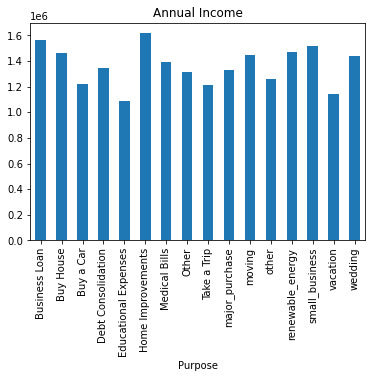

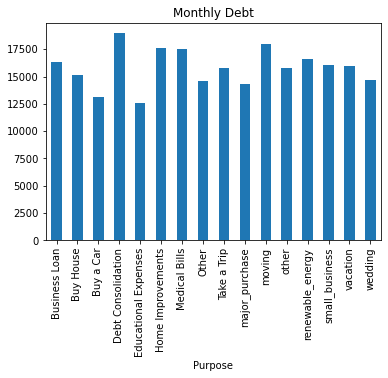

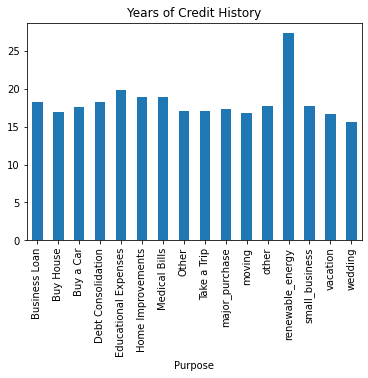

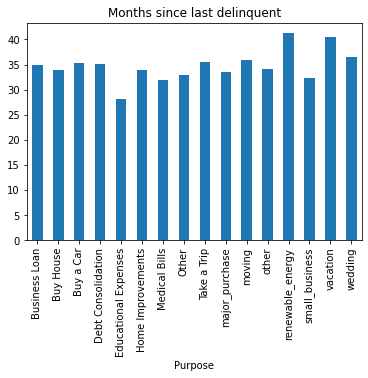

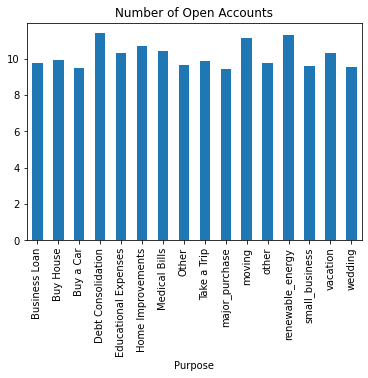

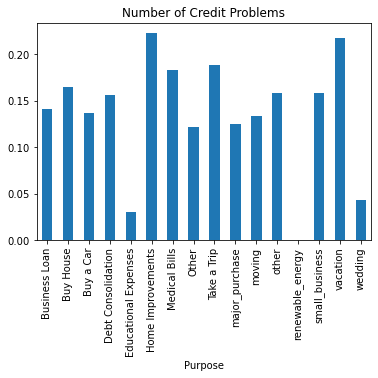

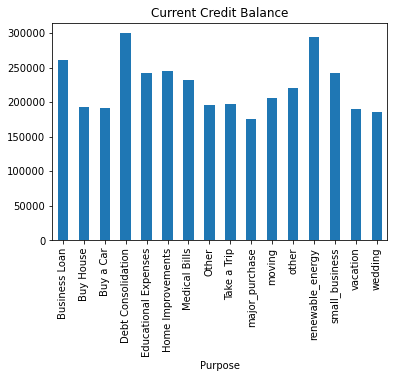

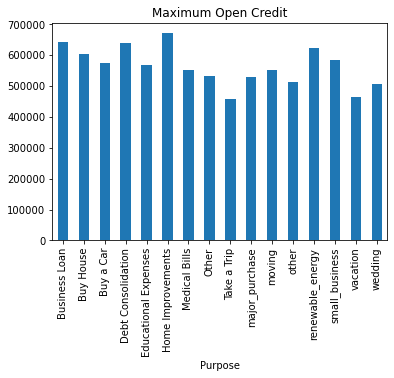

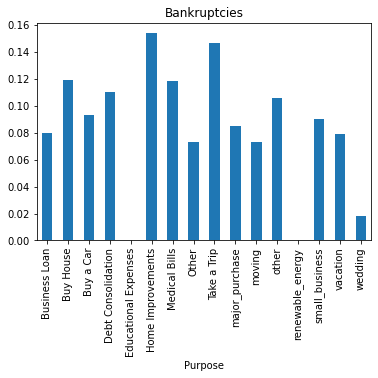

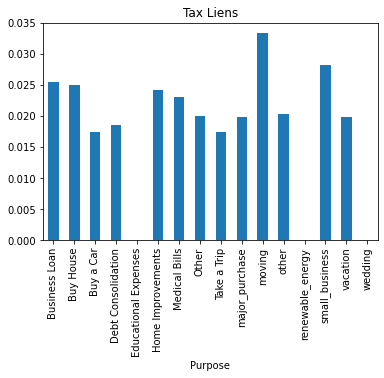

In [24]:
for cat_col in cat_cols:
    for num_col in num_cols:    
        df.groupby(cat_col)[num_col].mean().plot(kind='bar',title=num_col)
        plt.show()    


In [25]:
from scipy.stats import ttest_ind
cat1 = df[df['Term']=='Long Term']
cat2 = df[df['Term']=='Short Term']
for c in num_cols:
    print(c,ttest_ind(cat1[c].dropna(), cat2[c].dropna()))


Current Loan Amount Ttest_indResult(statistic=139.93471116581597, pvalue=0.0)
Credit Score Ttest_indResult(statistic=-150.12860727289572, pvalue=0.0)
Annual Income Ttest_indResult(statistic=35.51459372709173, pvalue=3.839151487100914e-274)
Monthly Debt Ttest_indResult(statistic=53.32427994585559, pvalue=0.0)
Years of Credit History Ttest_indResult(statistic=13.52154576928889, pvalue=1.2697199279025782e-41)
Months since last delinquent Ttest_indResult(statistic=-3.13734026468571, pvalue=0.0017059371081468372)
Number of Open Accounts Ttest_indResult(statistic=26.57857572806788, pvalue=4.171647834907584e-155)
Number of Credit Problems Ttest_indResult(statistic=-8.634581985495638, pvalue=5.978872795142185e-18)
Current Credit Balance Ttest_indResult(statistic=44.407978674278205, pvalue=0.0)
Maximum Open Credit Ttest_indResult(statistic=32.41507047161208, pvalue=2.623460632492447e-229)
Bankruptcies Ttest_indResult(statistic=-9.229730116869687, pvalue=2.7640663259602236e-20)
Tax Liens Ttest_i

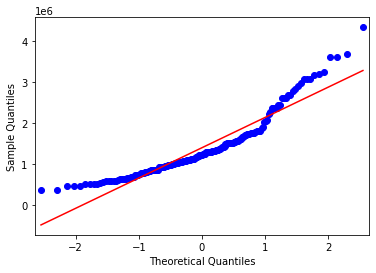

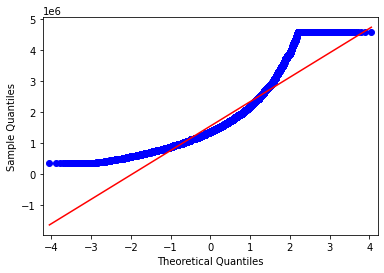

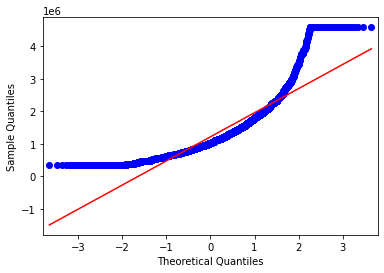

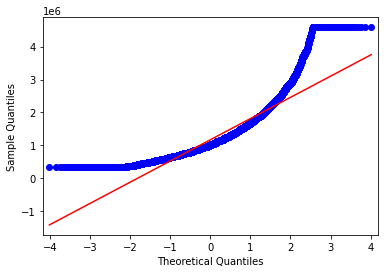

In [26]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
cat1 = df[df['Home Ownership']=='HaveMortgage']
cat2 = df[df['Home Ownership']=='Home Mortgage']
cat3 = df[df['Home Ownership']=='Own Home']
cat4 = df[df['Home Ownership']=='Rent']
qqplot(cat1['Annual Income'].dropna(),line='s')
qqplot(cat2['Annual Income'].dropna(),line='s')
qqplot(cat3['Annual Income'].dropna(),line='s')
qqplot(cat4['Annual Income'].dropna(),line='s')
pyplot.show()

In [27]:
from scipy import stats
cat1 = df[df['Home Ownership']=='HaveMortgage']
cat2 = df[df['Home Ownership']=='Home Mortgage']
cat3 = df[df['Home Ownership']=='Own Home']
cat4 = df[df['Home Ownership']=='Rent']
for c in num_cols:   
    f_val, p_val = stats.f_oneway(cat1[c].dropna(), cat2[c].dropna(),cat3[c].dropna(),cat4[c].dropna())            
    print (c,"--- One-way ANOVA P =", p_val )

Current Loan Amount --- One-way ANOVA P = 0.0
Credit Score --- One-way ANOVA P = 6.72524770287405e-33
Annual Income --- One-way ANOVA P = 0.0
Monthly Debt --- One-way ANOVA P = 0.0
Years of Credit History --- One-way ANOVA P = 0.0
Months since last delinquent --- One-way ANOVA P = 3.72775863146198e-34
Number of Open Accounts --- One-way ANOVA P = 0.0
Number of Credit Problems --- One-way ANOVA P = 0.00847969430681649
Current Credit Balance --- One-way ANOVA P = 0.0
Maximum Open Credit --- One-way ANOVA P = 0.0
Bankruptcies --- One-way ANOVA P = 0.28919861056488494
Tax Liens --- One-way ANOVA P = 0.01441348239539838


<Figure size 432x288 with 0 Axes>

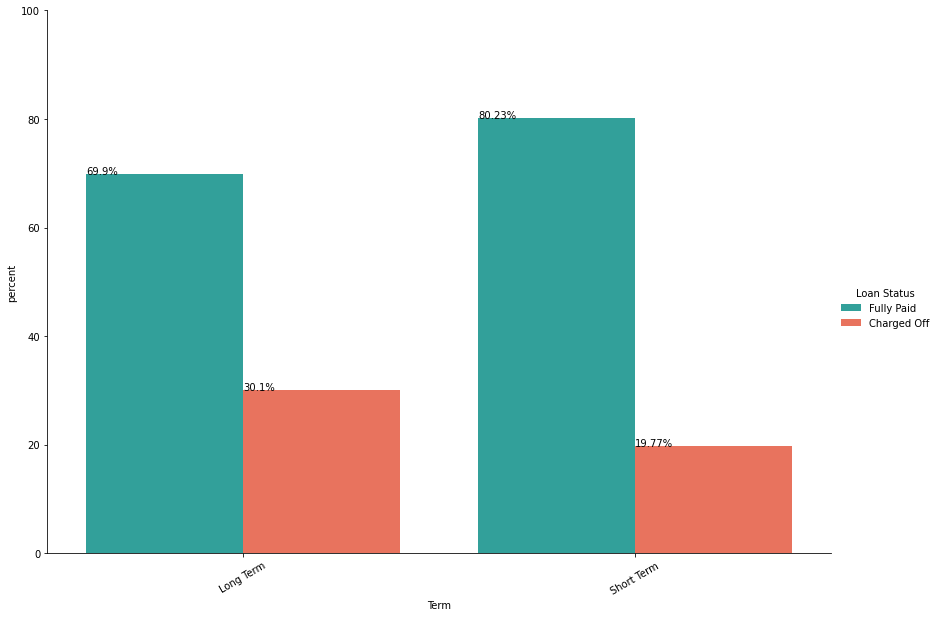

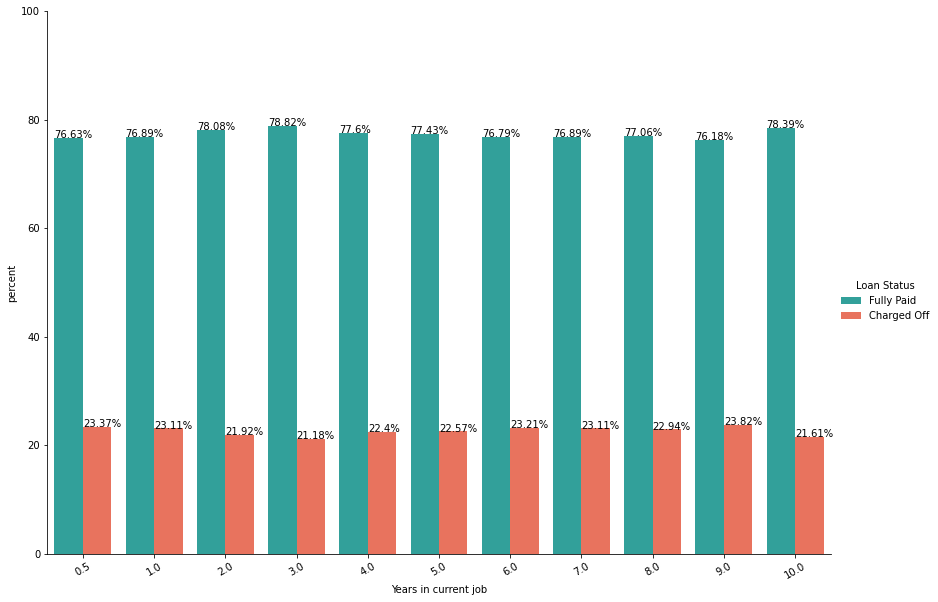

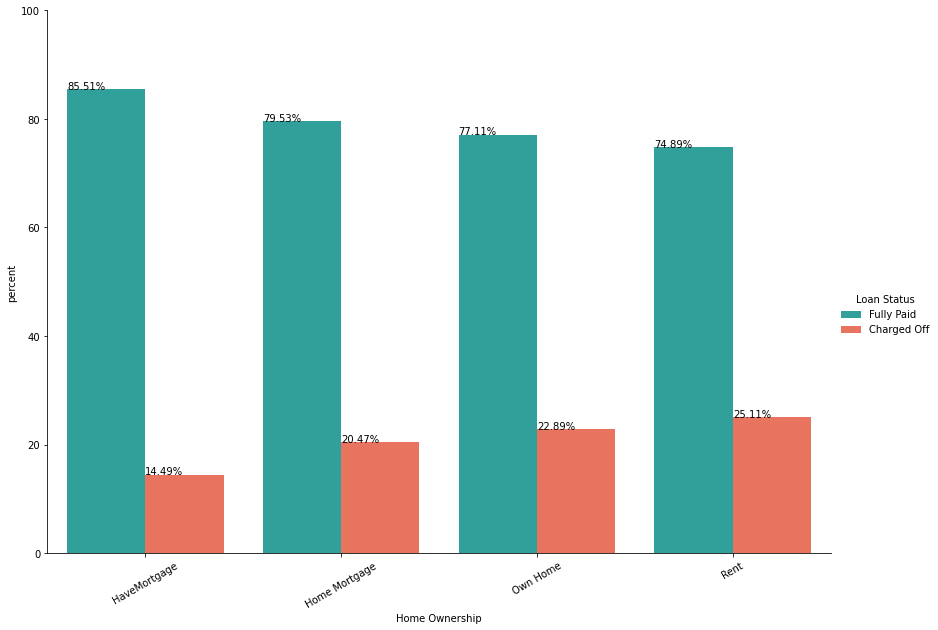

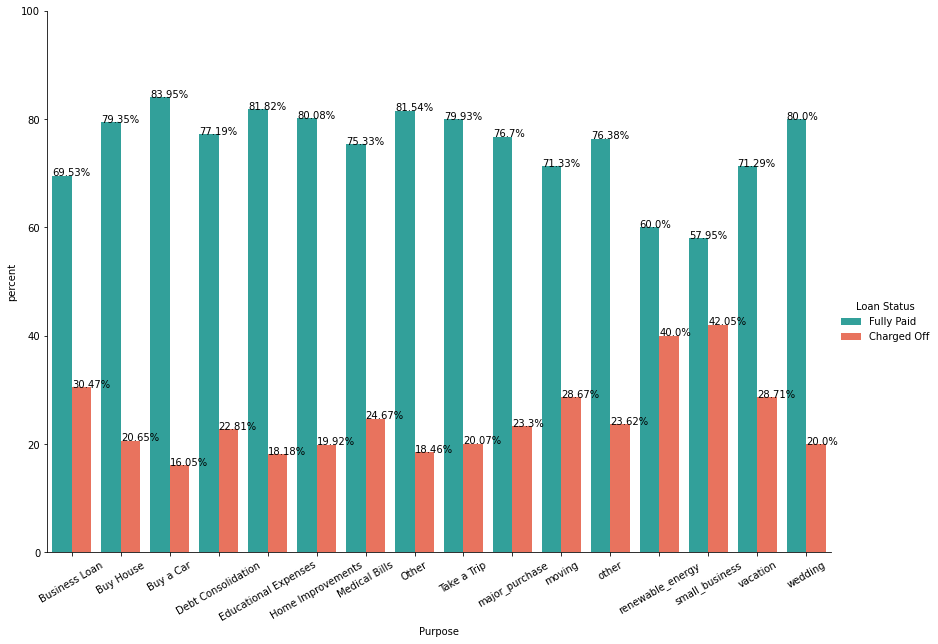

In [28]:
#Plot each attribute vs Class in percentage
y = 'Loan Status'
for i, predictor in enumerate(df[cat_cols].drop(columns=['Loan Status'])):
    plt.figure(i)
    df1 = df.groupby(predictor)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    g = sns.catplot(x=predictor,y='percent',hue=y,kind='bar',data=df1,
                    palette=sns.color_palette(['lightseagreen', 'tomato']),height=8.27, aspect=11.7/8.27)
    g.set_xticklabels(rotation=30)
    g.ax.set_ylim(0,100)

    for p in g.ax.patches:
        txt = str(np.nan_to_num(p.get_height().round(2))) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        txt_y=np.nan_to_num(txt_y)
        g.ax.text(txt_x,txt_y,txt)

## Data processing and cleaning

In [52]:
df=pd.read_sql_table(r"credit_train",engine_datahub)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [53]:
# limitPer = len(df) * .80
# df = df.dropna(thresh=limitPer, axis=1)

# limitPer=df.shape[1] * .50
# df = df.dropna(thresh=limitPer, axis=0)

df.shape
# df.head()

df['Years in current job']=df['Years in current job'].str[:2].replace({'< ':'0.5'}).astype(float)
num_cols=df.select_dtypes('number').columns.tolist()

cat_cols=df.select_dtypes(object).drop(['Loan ID','Customer ID'],axis=1).columns.tolist()

df['Credit Score']=np.where(df['Credit Score']>=1000,df['Credit Score']/10,df['Credit Score'])
df['Current Loan Amount']=np.where(df['Current Loan Amount']==99999999,df['Current Loan Amount'].median(),df['Current Loan Amount'])

df[num_cols]=df[num_cols].clip(lower=df[num_cols].quantile(0.01), upper=df[num_cols].quantile(0.99),axis=1)

# df.query('`Loan ID`.isnull()',engine='python')
df=df.query('`Loan ID`.notnull()',engine='python')

In [54]:
#replace mnissing value with median, a better representation of the center of the data if it's not normally ditributed

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for col in num_cols:
    df[col]=imputer.fit_transform(df[col].values.reshape(-1, 1))



In [55]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col in cat_cols:
    df[col]=imputer.fit_transform(df[col].values.reshape(-1, 1))

In [56]:
c='Purpose'
percentage=5
dct={}
series = pd.value_counts(df[c])
mask = (series/series.sum() * 100).lt(percentage)             
dct[c] = series[mask].index.values.tolist()
dct[c]
df[c] = np.where(df[c].isin(dct[c]),'Other',df[c])
df[c].value_counts()

Debt Consolidation    78552
Other                  9572
other                  6037
Home Improvements      5839
Name: Purpose, dtype: int64

In [59]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
18,Tax Liens,2
2,Loan Status,2
17,Bankruptcies,2
4,Term,2
14,Number of Credit Problems,3
8,Home Ownership,4
9,Purpose,4
7,Years in current job,11
13,Number of Open Accounts,25
12,Months since last delinquent,81


In [60]:
df.query('`Loan ID`.notnull()',engine='python')

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8.0,Home Mortgage,Home Improvements,5214.74,17.2,32.0,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,722.0,1174162.0,10.0,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,27.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,312246.0,Short Term,741.0,2231892.0,8.0,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3.0,Own Home,Debt Consolidation,8741.90,12.0,32.0,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,722.0,1174162.0,5.0,Rent,Debt Consolidation,20639.70,6.4,32.0,15.0,0.0,253460.0,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3f94c18c-ba8f-45d0-8610-88a684a410a9,2da51983-cfef-4b8f-a733-5dfaf69e9281,Fully Paid,147070.0,Short Term,725.0,475437.0,7.0,Own Home,other,2202.86,22.3,32.0,5.0,0.0,47766.0,658548.0,0.0,0.0
99996,06eba04f-58fc-424a-b666-ed72aa008900,77f2252a-b7d1-4b07-a746-1202a8304290,Fully Paid,312246.0,Short Term,732.0,1289416.0,1.0,Rent,Debt Consolidation,13109.05,9.4,21.0,22.0,0.0,153045.0,509234.0,0.0,0.0
99997,e1cb4050-eff5-4bdb-a1b0-aabd3f7eaac7,2ced5f10-bd60-4a11-9134-cadce4e7b0a3,Fully Paid,103136.0,Short Term,742.0,1150545.0,6.0,Rent,Debt Consolidation,7315.57,18.8,18.0,12.0,1.0,109554.0,537548.0,1.0,0.0
99998,81ab928b-d1a5-4523-9a3c-271ebb01b4fb,3e45ffda-99fd-4cfc-b8b8-446f4a505f36,Fully Paid,530332.0,Short Term,746.0,1717524.0,9.0,Rent,Debt Consolidation,9890.07,15.0,32.0,8.0,0.0,404225.0,738254.0,0.0,0.0


In [61]:
#check for missing values
df[df.isnull().any(axis=1)]

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens


In [62]:
#encode the attribute
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([each], axis=1)
    return df


cat_cols.remove('Loan Status')
df=one_hot(df,cat_cols)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Months since last delinquent,...,Term_Long Term,Term_Short Term,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Debt Consolidation,Purpose_Home Improvements,Purpose_Other,Purpose_other
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,709.0,1167493.0,8.0,5214.74,17.2,32.0,...,0,1,0,1,0,0,0,1,0,0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,722.0,1174162.0,10.0,33295.98,21.1,8.0,...,0,1,0,1,0,0,1,0,0,0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,312246.0,741.0,2231892.0,8.0,29200.53,14.9,29.0,...,0,1,0,0,1,0,1,0,0,0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,721.0,806949.0,3.0,8741.90,12.0,32.0,...,1,0,0,0,1,0,1,0,0,0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,722.0,1174162.0,5.0,20639.70,6.4,32.0,...,0,1,0,0,0,1,1,0,0,0


In [63]:
item_list = df.columns.tolist()
item_list = [e for e in item_list if e not in ('Loan ID','Customer ID','Loan Status','Loan Status encoded')]
item_list

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Years in current job',
 'Monthly Debt',
 'Years of Credit History',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Bankruptcies',
 'Tax Liens',
 'Term_Long Term',
 'Term_Short Term',
 'Home Ownership_HaveMortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_Debt Consolidation',
 'Purpose_Home Improvements',
 'Purpose_Other',
 'Purpose_other']

In [64]:
#double check the data to see if there is any missing values and all categorical attributes have been encoded.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Credit Score                  100000 non-null  float64
 5   Annual Income                 100000 non-null  float64
 6   Years in current job          100000 non-null  float64
 7   Monthly Debt                  100000 non-null  float64
 8   Years of Credit History       100000 non-null  float64
 9   Months since last delinquent  100000 non-null  float64
 10  Number of Open Accounts       100000 non-null  float64
 11  Number of Credit Problems     100000 non-null  float64
 12  Current Credit Balance        100000 non-null

## Create the function to train the model, test it, and visualize the results

In [65]:
def prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Loan Status 0", "Loan Status 1"],
                        y = ["Loan Status 0", "Loan Status 1"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        display(coef_sumry)
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        

        
    py.iplot(fig)
    return(coef_sumry,algorithm)



## Feed the parameters to the function created above
Split the data into train dataset and test dataset and use the Hyper Parameters obtained above to generate a Logistic Regression instance and execute the function.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import statsmodels.api as sm
# from yellowbrick.classifier import DiscriminationThreshold

#For better performance use MinMaxScaler to scale and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x =pd.DataFrame(scaler.fit_transform(df[item_list]),columns=item_list)
                   
df['Loan Status encoded']=np.where(df['Loan Status']=='Fully Paid',0,1)   

#splitting the principal training dataset to subtrain and subtest datasets

x_train, x_test, y_train, y_test = train_test_split(df_x, df['Loan Status encoded'], 
                                                    test_size = .3)
from sklearn.linear_model import LogisticRegression
import plotly.graph_objs as go # visualization
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
#Baseline model        
# logit = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
#                            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
#                            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
#                            verbose=0, warm_start=False)
logit = LogisticRegression(C=0.1,penalty='l1',solver='liblinear')

coef_sumry, model=prediction(logit, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=False)

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87     23239
           1       0.17      0.00      0.00      6761

    accuracy                           0.77     30000
   macro avg       0.47      0.50      0.44     30000
weighted avg       0.64      0.77      0.68     30000

Accuracy Score: 0.7745
Area under curve: 0.49996637577843206 



,coefficients,features
9,1.017736,Current Credit Balance
4,0.487417,Monthly Debt
0,0.383801,Current Loan Amount
7,0.358353,Number of Open Accounts
12,0.160468,Tax Liens
18,0.076434,Home Ownership_Rent
21,0.010881,Purpose_Other
17,0.000000,Home Ownership_Own Home
15,0.000000,Home Ownership_HaveMortgage
13,0.000000,Term_Long Term


### Interpret the results:
<!-- An Accuracy Score of 0.96 on Test data is a very good score with 1 being perfect 100% correct prediction. 
From the confusion Matrix we know that out of 194 predictions, only 7 mistake. Area under curve(True Positive/ False Positive), 
another model performance metric which often is used for unbalanced samples, is 0.965, also near perfect. 
The Feature Importance chart  suggests that  Money_Values, PARA_B, PARA_A, Score and District_Loss are more powerful predictors for Risk. 
 -->
<!-- Overall we have a very good model that can predict Risk. -->

# Productization of your Insights/Recommendations

In [80]:
df=pd.read_sql_table(r"credit_test",engine_datahub)
df.head()


# limitPer = len(df) * .80
# df = df.dropna(thresh=limitPer, axis=1)

# limitPer=df.shape[1] * .50
# df = df.dropna(thresh=limitPer, axis=0)

df.shape

df['Years in current job']=df['Years in current job'].str[:2].replace({'< ':'0.5'}).astype(float)
num_cols=df.select_dtypes('number').columns.tolist()

cat_cols=df.select_dtypes(object).drop(['Loan ID','Customer ID'],axis=1).columns.tolist()

df['Credit Score']=np.where(df['Credit Score']>=1000,df['Credit Score']/10,df['Credit Score'])
df['Current Loan Amount']=np.where(df['Current Loan Amount']==99999999,df['Current Loan Amount'].median(),df['Current Loan Amount'])

df[num_cols]=df[num_cols].clip(lower=df[num_cols].quantile(0.01), upper=df[num_cols].quantile(0.99),axis=1)

# df.query('`Loan ID`.isnull()',engine='python')
df=df.query('`Loan ID`.notnull()',engine='python')

#replace mnissing value with median, a better representation of the center of the data if it's not normally ditributed

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for col in num_cols:
    df[col]=imputer.fit_transform(df[col].values.reshape(-1, 1))



imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col in cat_cols:
    df[col]=imputer.fit_transform(df[col].values.reshape(-1, 1))

c='Purpose'
percentage=5
dct={}
series = pd.value_counts(df[c])
mask = (series/series.sum() * 100).lt(percentage)             
dct[c] = series[mask].index.values.tolist()
dct[c]
df[c] = np.where(df[c].isin(dct[c]),'Other',df[c])
df[c].value_counts()

unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

#encode the attribute
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([each], axis=1)
    return df


# cat_cols.remove('Loan Status')
df=one_hot(df,cat_cols)
df.head()

item_list = df.columns.tolist()
item_list = [e for e in item_list if e not in ('Loan ID','Customer ID','Loan Status','Loan Status encoded')]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x =pd.DataFrame(scaler.fit_transform(df[item_list]),columns=item_list)
                   


,Loan ID,Customer ID,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,f738779f-c726-40dc-92cf-689d73af533d,ded0b3c3-6bf4-4091-8726-47039f2c1b90,611314.0,Short Term,747.0,2074116.0,10+ years,Home Mortgage,Debt Consolidation,42000.83,21.8,NaN,9.0,0.0,621908.0,1058970.0,0.0,0.0
1,6dcc0947-164d-476c-a1de-3ae7283dde0a,1630e6e3-34e3-461a-8fda-09297d3140c8,266662.0,Short Term,734.0,1919190.0,10+ years,Home Mortgage,Debt Consolidation,36624.40,19.4,NaN,11.0,0.0,679573.0,904442.0,0.0,0.0
2,f7744d01-894b-49c3-8777-fc6431a2cff1,2c60938b-ad2b-4702-804d-eeca43949c52,153494.0,Short Term,709.0,871112.0,2 years,Rent,Debt Consolidation,8391.73,12.5,10.0,10.0,0.0,38532.0,388036.0,0.0,0.0
3,83721ffb-b99a-4a0f-aea5-ef472a138b41,12116614-2f3c-4d16-ad34-d92883718806,176242.0,Short Term,727.0,780083.0,10+ years,Rent,Debt Consolidation,16771.87,16.5,27.0,16.0,1.0,156940.0,531322.0,1.0,0.0
4,08f3789f-5714-4b10-929d-e1527ab5e5a3,39888105-fd5f-4023-860a-30a3e6f5ccb7,321992.0,Short Term,744.0,1761148.0,10+ years,Home Mortgage,Debt Consolidation,39478.77,26.0,44.0,14.0,0.0,359765.0,468072.0,0.0,0.0


In [82]:
df['probabily'] = model.predict_proba(df_x)[:,1]
df.sort_values(by='probabily',ascending=False).head(50)


,Loan ID,Customer ID,Current Loan Amount,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,...,Term_Short Term,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Debt Consolidation,Purpose_Home Improvements,Purpose_Other,Purpose_other,probabily
5870,3df6ff34-a3b4-49f4-a72a-e23fc77f4072,ffffc64c-8637-4a08-b2e7-5b67bd8da124,591888.0,633.0,1161774.0,10.0,32336.10,14.4,45.0,21.0,...,0,0,0,0,1,1,0,0,0,0.510616
8967,df7a201e-1764-439c-b439-59bf6cf12692,4b61d79f-c779-46e2-b0a7-8e7f058fcc88,759924.0,723.0,1168272.0,10.0,52346.90,15.2,4.0,23.0,...,0,0,1,0,0,1,0,0,0,0.510456
7594,ad3db3ca-9ea5-4b14-8e57-89bc7c5d4b70,d396b3ae-f4b4-4270-8cb4-d45622a36348,543334.0,646.0,1070688.0,5.0,21056.94,15.0,32.0,18.0,...,0,0,0,0,1,0,0,1,0,0.490221
2266,3648867b-6357-4fef-9c02-c59df505197e,fa00a69b-1190-4932-b01b-83b958c19cb9,242660.0,667.0,467115.0,1.0,10081.59,22.9,24.0,19.0,...,0,0,0,0,1,0,0,0,1,0.487017
350,4ceaf239-8680-45a4-9b95-f4ed2e717cc7,b735beb0-0c84-47d4-981f-9bfb69d1c319,545710.0,640.0,1470448.0,10.0,37128.66,17.8,32.0,22.0,...,0,0,0,0,1,1,0,0,0,0.479158
944,2d1b843b-2b90-4a99-94b5-29acf09af541,509274f0-b7a0-4d52-a3c6-d0c227ca8c35,669768.0,723.0,1168272.0,10.0,48845.58,20.1,31.0,22.0,...,0,0,1,0,0,1,0,0,0,0.473138
6385,417275b9-3c1f-4e89-b557-107c96b77e41,f816a0f9-6630-4d46-8d21-7b6c1ff3b865,307846.0,659.0,763781.0,7.0,17439.72,18.3,32.0,25.0,...,0,0,0,0,1,1,0,0,0,0.471549
5888,4d7a0d55-7ecb-4caa-8ed9-9312f4e9a9c1,54bf285a-fb16-4248-a8c1-b10c2738b0df,328460.0,649.0,1267015.0,7.0,37588.27,17.6,2.0,16.0,...,0,0,0,0,1,0,0,1,0,0.470707
343,6f57ec66-e98e-4b87-9430-6da1ceefb465,660e81c9-180a-4300-9206-c8be6e403127,763532.0,649.0,1714484.0,10.0,48291.16,31.8,14.0,21.0,...,0,0,0,0,1,1,0,0,0,0.469576
4361,8723d3d5-1ab7-45e4-9b7d-19b9e0a0717e,9c5b1555-ee40-4e19-92ac-39ec4ca4aec5,424644.0,635.0,816905.0,6.0,20150.45,17.0,61.0,22.0,...,0,0,0,0,1,1,0,0,0,0.468973


In [91]:
import pyodbc
import urllib
import sqlalchemy

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))
df=df.drop('Purpose_other',axis=1)
df.to_sql('credit_prediction',engine_datahub)